In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, recall_score, r2_score, mean_squared_error
from sklearn.ensemble import BaggingClassifier, BaggingRegressor, RandomForestClassifier, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt

In [4]:
#.read_csv('concrete.csv')
import warnings
warnings.filterwarnings("ignore")
prima=pd.read_csv('concrete.csv')
#prima.columns=['preg', 'glu', 'bp', 'sft', 'ins', 'bmi', 'dpf', 'age', 'outcome']
x =  prima.drop("strength", axis=1)
y =  prima.pop("strength")
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=1,test_size=.3)
scaler=StandardScaler()
scaledx_train=scaler.fit_transform(x_train)
scaledx_test=scaler.transform(x_test)

                                     Metric  Metric(Avg.)  Variance   CI(+/-)  \
Model                                                                           
LinearRegression                   R2 score      0.564930  0.019186  0.277027   
Linear Regression(Polynomial)      R2 score      0.564930  0.019186  0.277027   
KNeighborsRegressor                R2 score      0.666368  0.011089  0.210607   
DecisionTreeRegressor              R2 score      0.809692  0.006846  0.165478   
Regularized DecisionTreeRegressor  R2 score      0.832171  0.005365  0.146498   
RandomForestRegressor              R2 score      0.889168  0.002542  0.100829   
BaggingRegressor                   R2 score      0.883588  0.002197  0.093742   
AdaBoostRegressor                  R2 score      0.778214  0.001522  0.078036   
GradientBoostingRegressor          R2 score      0.894733  0.001624  0.080606   

                                    CV_param  CV_param_value  
Model                                        

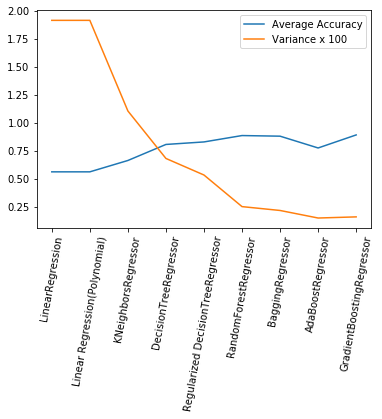

In [26]:
report=[]
for model in [LinearRegression(),KNeighborsRegressor(),DecisionTreeRegressor(),
              RandomForestRegressor(),BaggingRegressor(),
             AdaBoostRegressor(),GradientBoostingRegressor()]:
    modelfit=model.fit(scaledx_train,y_train)
    y_pred=modelfit.predict(scaledx_test)
    scores = cross_val_score(modelfit, scaledx_train, y_train, cv=20)
    #print(str(model).partition('(')[0],'R2 score',scores.mean())
    report.append([str(model).partition('(')[0],'R2 score',scores.mean(),scores.var(),scores.std()*2,np.nan,np.nan])
    
    if str(model).partition('(')[0]=='LinearRegression': # Linear Model Tuning
        polyr2=[]
        deg=1
        for i in range(1,5):
            poly = PolynomialFeatures(i)
            scaledx_train_poly=poly.fit_transform(scaledx_train)
            scaledx_test_poly=poly.transform(scaledx_test)
            lm=LinearRegression()
            lm=lm.fit(scaledx_train_poly,y_train)
            y_pred=lm.predict(scaledx_test_poly)
            if i>1:
                if (polyr2[-1]<r2_score(y_test,y_pred)) & (i>1):
                    deg=i
            polyr2.append(r2_score(y_test,y_pred))
        #polyr2[deg-1]
        poly = PolynomialFeatures(deg)
        scaledx_train_poly=poly.fit_transform(scaledx_train)
        scaledx_test_poly=poly.transform(scaledx_test)
        lm=LinearRegression()
        lm=lm.fit(scaledx_train_poly,y_train)
        scores = cross_val_score(lm, scaledx_train, y_train, cv=20)
        #print('Linear Regression(Polynomial) R2 score',polyr2[deg-1],'; degree=',deg)
        report.append(['Linear Regression(Polynomial)','R2 score',scores.mean(),scores.var(),scores.std()*2,'degree',deg])
    elif str(model).partition('(')[0]=='DecisionTreeRegressor': # Decision tree tuning        
        dt_reg=DecisionTreeRegressor(random_state=1)
        param={'max_depth':range(1,100)}
        dt_reg=RandomizedSearchCV(dt_reg,param_distributions=param,cv=5)
        dt_reg=dt_reg.fit(scaledx_train,y_train)
        y_pred_dt_reg=dt_reg.predict(scaledx_test)
        scores = cross_val_score(dt_reg, scaledx_train, y_train, cv=20)
        #print('Regularized DecisionTreeRegressor R2 score',r2_score(y_test,y_pred_dt_reg),dt_reg.best_params_)
        report.append(['Regularized DecisionTreeRegressor', 'R2 score',scores.mean(),scores.var(),scores.std()*2,'max_depth',dt_reg.best_params_['max_depth']])

        
Final_report=pd.DataFrame(report,columns=['Model', 'Metric', 'Metric(Avg.)', 'Variance', 'CI(+/-)','CV_param', 'CV_param_value'])
Final_report.set_index("Model",inplace=True)
print(Final_report)
plt.plot(Final_report.index,Final_report['Metric(Avg.)'],label='Average Accuracy')
plt.plot(Final_report.index,Final_report['Variance']*100,label='Variance x 100')
plt.xticks(rotation=80)
plt.legend()
plt.show()